In [7]:
def readTextFiles(path):
    with open(path) as f:
        captions = f.read()
    return captions

In [8]:
captions = readTextFiles("Data/Flickr_TextData/Flickr8k.token.txt")

In [9]:
captions = captions.split("\n")

In [11]:
print(captions[-1])

In [12]:
print(captions[-2])

997722733_0cb5439472.jpg#4	A rock climber practices on a rock climbing wall .


In [13]:
captions = captions[:-1]

In [14]:
print(captions[-1])

997722733_0cb5439472.jpg#4	A rock climber practices on a rock climbing wall .


In [17]:
print(captions[0:10])

['1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .', '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .', '1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .', '1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .', '1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .', '1001773457_577c3a7d70.jpg#0\tA black dog and a spotted dog are fighting', '1001773457_577c3a7d70.jpg#1\tA black dog and a tri-colored dog playing with each other on the road .', '1001773457_577c3a7d70.jpg#2\tA black dog and a white dog with brown spots are staring at each other in the street .', '1001773457_577c3a7d70.jpg#3\tTwo dogs of different breeds looking at each other on the road .', '1001773457_577c3a7d70.jpg#4\tTwo dogs on pavement moving toward each other .']


In [9]:
# Dictionary to map each image to its captions

In [18]:
descriptions = {}

for x in captions:
    a,b = (x.split("\t"))
    a=a.split(".")[0]
    
    if(descriptions.get(a) is None):
            descriptions[a] = []
    descriptions[a].append(b)
    

In [19]:
(descriptions["997722733_0cb5439472"])

['A man in a pink shirt climbs a rock face',
 'A man is rock climbing high in the air .',
 'A person in a red shirt climbing up a rock face covered in assist handles .',
 'A rock climber in a red shirt .',
 'A rock climber practices on a rock climbing wall .']

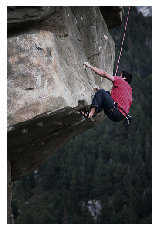

In [12]:
IMG_PATH = "Data/Images/"
import cv2
import matplotlib.pyplot as plt

img = cv2.imread(IMG_PATH+"997722733_0cb5439472.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()

# Data Cleaning

In [1]:
import pandas as pd
import numpy as np
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, Dropout, Embedding, LSTM
from keras.layers.merge import add

In [2]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+"," ",sentence)
    sentence=sentence.split()
    
    sentence = [s for s in sentence if len(s)>1]
    sentence = " ".join(sentence)
    return sentence

In [15]:
clean_text("A cat is sitting over the house no. 64")

'cat is sitting over the house no'

In [20]:
for key,caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])

In [21]:
descriptions["997722733_0cb5439472"]

['man in pink shirt climbs rock face',
 'man is rock climbing high in the air',
 'person in red shirt climbing up rock face covered in assist handles',
 'rock climber in red shirt',
 'rock climber practices on rock climbing wall']

In [22]:
f = open("descriptions.txt","w")
f.write(str(descriptions))
f.close()

 # Defining vocab

In [23]:
descriptions = None
with open("descriptions.txt",'r') as f:
    descriptions = f.read()
    
descriptions = json.loads(descriptions.replace("'","\""))

In [24]:
vocab = set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]

In [25]:
print(len(vocab))

8424


In [26]:
total_words = []

for key in descriptions.keys():
    [total_words.append(w) for desc in descriptions[key] for w in desc.split()]

In [27]:
import collections

counter = collections.Counter(total_words)
freq_cnt = dict(counter)

print(len(freq_cnt.keys()))

8424


In [28]:
sorted_freq_cnt = sorted(freq_cnt.items(),reverse=True, key=lambda x:x[1])

sorted_freq_cnt = [x for x in sorted_freq_cnt if x[1]>10]
total_words = [x[0] for x in sorted_freq_cnt]

In [29]:
print(len(total_words))

1845


# Train and Test data

In [26]:
train_file_data = readTextFiles("Data/Flickr_TextData/Flickr_8k.trainImages.txt")
test_file_data = readTextFiles("Data/Flickr_TextData/Flickr_8k.testImages.txt")

In [27]:
train = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]

In [28]:
print(train[:5])

['2513260012_03d33305cf', '2903617548_d3e38d7f88', '3338291921_fe7ae0c8f8', '488416045_1c6d903fe0', '2644326817_8f45080b87']


### Adding start and end token to captions

In [29]:
train_descriptions = {}
for img_id in train:
    train_descriptions[img_id] = []
    for cap in descriptions[img_id]:
        cap_to_append = "<s>"+cap+"<e>"
        train_descriptions[img_id].append(cap_to_append)

In [30]:
train_descriptions["2513260012_03d33305cf"]

['<s>black dog is running after white dog in the snow<e>',
 '<s>black dog chasing brown dog through snow<e>',
 '<s>two dogs chase each other across the snowy ground<e>',
 '<s>two dogs play together in the snow<e>',
 '<s>two dogs running through low lying body of water<e>']

In [31]:
model = ResNet50(weights="imagenet", input_shape=(224,224,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [32]:
new_model = Model(model.input,model.layers[-2].output)  #prev model GAP layer as output layer

In [33]:
def preprocess_img(img):
    img = image.load_img(img, target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    #Normalisation
    img = preprocess_input(img)
    return img

In [34]:
img = preprocess_img(IMG_PATH+"997722733_0cb5439472.jpg")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


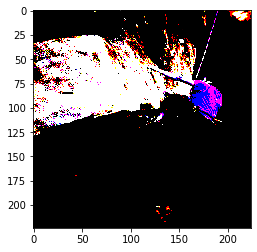

In [35]:
plt.imshow(img[0])
plt.show()

In [36]:
def encode_img(img):
    img = preprocess_img(img)
    feature_vector = new_model.predict(img)
    feature_vector = feature_vector.reshape((-1,))
    return feature_vector

In [37]:
encoding_train = {}
start_t = time()
for ix, img_id in enumerate(train):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_train[img_id] = encode_img(img_path)
    
    if ix%100==0:
        print("Encoding in progress Time Step %d"%ix)
end_t = time()
print("Total time taken: ",end_t-start_t)

Encoding in progress Time Step 0
Encoding in progress Time Step 100
Encoding in progress Time Step 200
Encoding in progress Time Step 300
Encoding in progress Time Step 400
Encoding in progress Time Step 500
Encoding in progress Time Step 600
Encoding in progress Time Step 700
Encoding in progress Time Step 800
Encoding in progress Time Step 900
Encoding in progress Time Step 1000
Encoding in progress Time Step 1100
Encoding in progress Time Step 1200
Encoding in progress Time Step 1300
Encoding in progress Time Step 1400
Encoding in progress Time Step 1500
Encoding in progress Time Step 1600
Encoding in progress Time Step 1700
Encoding in progress Time Step 1800
Encoding in progress Time Step 1900
Encoding in progress Time Step 2000
Encoding in progress Time Step 2100
Encoding in progress Time Step 2200
Encoding in progress Time Step 2300
Encoding in progress Time Step 2400
Encoding in progress Time Step 2500
Encoding in progress Time Step 2600
Encoding in progress Time Step 2700
Enco

In [38]:
with open("encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)

In [39]:
encoding_test = {}
start_t = time()
for ix, img_id in enumerate(test):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_test[img_id] = encode_img(img_path)
    
    if ix%100==0:
        print("Encoding in progress Time Step %d"%ix)
end_t = time()
print("Total time taken: ",end_t-start_t)

Encoding in progress Time Step 0
Encoding in progress Time Step 100
Encoding in progress Time Step 200
Encoding in progress Time Step 300
Encoding in progress Time Step 400
Encoding in progress Time Step 500
Encoding in progress Time Step 600
Encoding in progress Time Step 700
Encoding in progress Time Step 800
Encoding in progress Time Step 900
Total time taken:  165.73936581611633


In [40]:
with open("encoded_test_features.pkl","wb") as f:
    pickle.dump(encoding_test,f)

# Pre-processing Captions

In [30]:
word2idx = {}
idx2word = {}
for i, word in enumerate(total_words):
    word2idx[word] = i+1
    idx2word[i+1] = word
    

In [31]:
# There are 1845 words
idx2word[1846] = "<s>"
word2idx["<s>"] = 1846
idx2word[1847] = "<e>"
word2idx["<e>"] = 1847

In [32]:
print("Vocab size is: ",len(word2idx)+1)
vocab_size=len(word2idx)+1

Vocab size is:  1848


In [34]:
with open("./storage/word2idx.pkl", "wb") as w2i:
    pickle.dump(word2idx,w2i)
with open("./storage/idx2word.pkl", "wb") as i2w:
    pickle.dump(idx2word,i2w)

In [48]:
max_len=0
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len = max(max_len,len(cap.split()))
print(max_len)

33


# Data Generator

In [49]:
def data_generator(train_descriptions, encoding_train, word2idx, max_len, vocab_size, batch_size=128):
    X1, X2, y=[], [], []
    n=0
    
    while True:
        for key, desc_list in train_descriptions.items():
            n += 1
            photo = encoding_train[key+".jpg"]
            
            for desc in desc_list:
                seq = [word2idx[word] for word in desc.split() if word in word2idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    xi = pad_sequences([xi],maxlen=max_len, value=0, padding="post")[0]
                    yi = to_categorical([yi], num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                if n== batch_size:
                    yield ([np.array(X1), np.array(X2)], np.array(y))
                    
                    X1, X2, y = [],[],[]
                    n=0
    

# Word Embeddings

In [58]:
f = open("glove.6B.50d.txt", encoding="utf-8")

In [59]:
embedding_index = {}

for line in f:
    values = line.split()
    word = values[0]
    word_embedding = np.array(values[1:], dtype="float")
    embedding_index[word] = word_embedding

In [60]:
f.close()

In [61]:
embedding_index["apple"]

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [65]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size, emb_dim))
    
    for word, idx in word2idx.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
    return matrix

In [66]:
embedding_matrix = get_embedding_matrix()

In [67]:
embedding_matrix.shape

(1848, 50)

In [75]:
embedding_matrix[1846]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

# Defining the Model

In [76]:
input_img_features =  Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256, activation="relu")(inp_img1)


In [77]:
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size, output_dim=50, mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [78]:
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation="relu")(decoder1)
outputs = Dense(vocab_size, activation="softmax")(decoder2)

In [79]:
model = Model(inputs=[input_img_features, input_captions], outputs=outputs)

In [80]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 33)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 33, 50)       92400       input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [81]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable=False

In [82]:
model.compile(loss="categorical_crossentropy", optimizer="adam")

In [84]:
epochs = 20
batch_size = 3
steps = len(train_descriptions)//batch_size

In [86]:
def train():
    for i in range(epochs):
        generator = data_generator(train_descriptions, encoding_train, word2idx, max_len, vocab_size, batch_size)
        model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
        model.save("./model_weights/model_"+str(i)+".h5")

In [94]:
#load wts

from keras import backend as K
K.tensorflow_backend._get_available_gpus()


AttributeError: module 'tensorflow.keras.backend' has no attribute 'tensorflow_backend'

# Predicting

In [87]:
def predict_caption(photo):
    inp_text="<s>"
    for i in range(max_len):
        sequence = [word2idx[w] for w in inp_text.split() if w in word2idx]
        sequence = pad_sequences([sequence], maxlen=max_len, padding="post")
        
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax()
        word = idx2word[ypred]
        inp_text +=" "+word
        if word == "<e>":
            break
    final_caption = inp_text.split()[1:-1]
    final_caption = " ".join(final_caption)
    return final_caption

uses uses uses uses uses uses uses uses uses uses uses uses uses uses uses uses uses uses uses uses uses uses uses uses uses uses uses uses uses uses uses uses


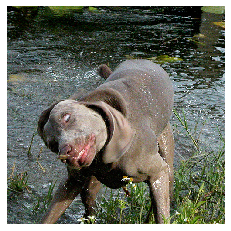

surfing surfing surfing surfing surfing surfing surfing surfing surfing surfing surfing surfing surfing surfing surfing surfing surfing surfing surfing surfing surfing surfing surfing surfing surfing surfing surfing surfing surfing surfing surfing surfing


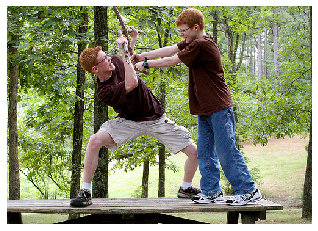

cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon


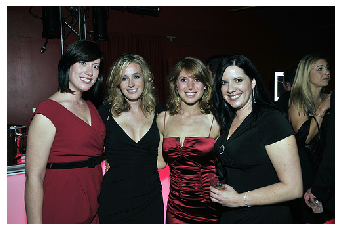

raises uses uses uses point uses cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon


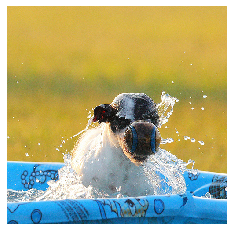

moves moves moves moves flowers moves moves moves moves flowers moves moves moves moves flowers moves moves moves moves flowers moves moves moves moves flowers moves moves moves moves flowers moves moves


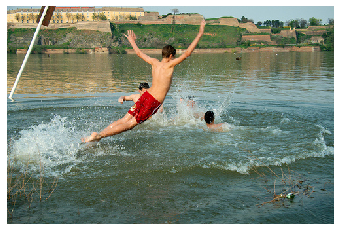

cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon


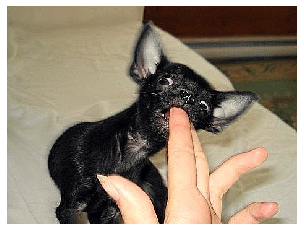

follow follow follow follow follow follow follow follow follow follow follow follow follow follow follow follow follow follow follow follow follow follow follow follow follow follow follow follow follow follow follow follow


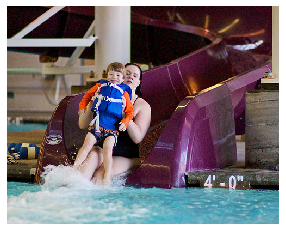

makes cannon makes cannon makes cannon makes cannon makes cannon makes cannon makes cannon makes cannon makes cannon makes cannon makes cannon makes cannon makes cannon makes cannon makes cannon makes cannon


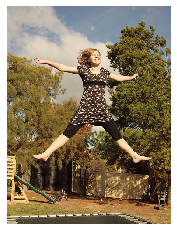

surfing surfing surfing surfing surfing bikinis surfing surfing surfing bikinis surfing surfing surfing surfing bikinis surfing surfing surfing surfing bikinis surfing surfing surfing surfing bikinis surfing surfing surfing surfing surfing bikinis surfing


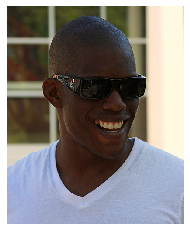

makes deck deck deck deck deck deck deck deck deck deck deck deck deck deck deck deck deck deck deck deck deck deck deck deck deck deck deck deck deck deck deck


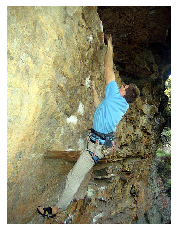

makes makes terrain terrain terrain terrain terrain terrain terrain terrain terrain terrain terrain terrain terrain terrain terrain terrain terrain terrain terrain terrain terrain terrain terrain terrain terrain terrain terrain terrain terrain terrain


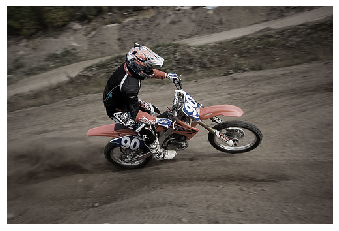

makes makes makes makes makes makes makes makes makes makes makes makes makes makes makes makes makes makes makes makes makes makes makes makes makes makes makes makes makes makes makes makes


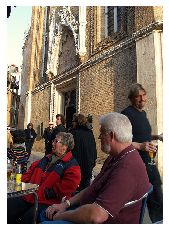

cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon cannon


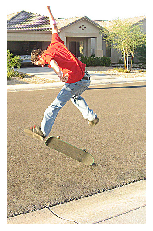

forward forward forward forward forward forward forward forward forward forward forward forward forward forward forward forward forward forward forward forward forward forward forward forward forward forward forward forward forward forward forward forward


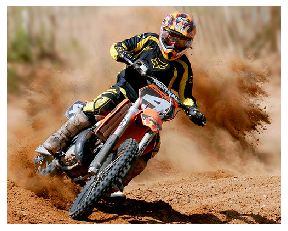

surfing surfing surfing surfing surfing surfing surfing surfing surfing surfing surfing surfing surfing surfing surfing surfing surfing surfing surfing surfing surfing surfing surfing surfing surfing surfing surfing surfing surfing surfing surfing surfing


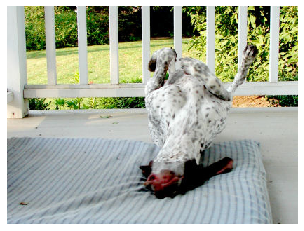

In [91]:
for i in range(15):
    no = np.random.randint(0,1000)
    img_name = list(encoding_test.keys())[no]
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    
    i = plt.imread("Data/Images/"+img_name+".jpg")
    caption = predict_caption(photo_2048)
    print(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()
    